### 1. 필요 모듈 불러오기

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

### 2. 데이터셋 준비 및 확인(클래스명 비율을 고려한 분할) - 경우1에 해당

In [3]:
# !pip install scikit-learn

In [6]:
from sklearn.model_selection import train_test_split # 필요 모듈 불러오기

## 데이터셋 분할 난수 설정
seed_num = 0 # 분할 난수 설정
np.random.seed(seed_num)  # numpy의 난수 생성기 시드 고정
torch.manual_seed(seed_num)  # PyTorch의 난수 생성기 시드 고정

# 폴더에서 데이터 불러오기
dataset = ImageFolder(root='../data/resnet_data/')
dataset_indices = list(range(len(dataset)))

# train/val/test -> 80/10/10
# 데이터셋의 레이블만 추출
targets = dataset.targets # 전체 데이터셋의 label 가져오기
print(targets)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [4]:
dataset.class_to_idx

{'마동석': 0, '박보영': 1, '차은우': 2, '카리나': 3}

In [8]:
# 첫번째 분할하기 train: val+test -> 80:20
train_indices, val_test_indices = train_test_split(dataset_indices, test_size=0.2, stratify=targets, random_state=seed_num)
val_test_target= [targets[i] for i in val_test_indices]

In [10]:
# 두번째 분할하기 val: test -> 10:10
val_idx, test_idx = train_test_split(val_test_indices, test_size=0.5, stratify=val_test_target, random_state=seed_num)

# Subset을 사용하여 최종 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [12]:
print(len(dataset), len(train_dataset), len(val_dataset), len(test_dataset))

152 121 15 16


In [7]:
class_idx = dataset.class_to_idx # 클래스명 딕셔너리
class_names = dict([(value, key) for key, value in class_idx.items()]) # key, value 값 순서 바꾸기
class_names

{0: '마동석', 1: '박보영', 2: '차은우', 3: '카리나'}

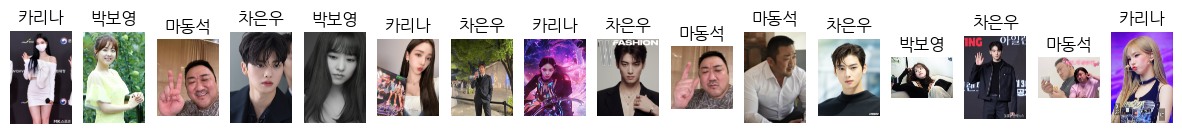

In [13]:
plt.figure(figsize=(15,8))
for idx, item in enumerate(test_dataset, start=1):
    plt.subplot(1,len(test_dataset),idx)
    image = item[0]
    class_name = class_names[item[1]] # 변환한 딕셔너리
    plt.title(class_name)
    plt.axis('off')  # 축과 눈금 제거
    plt.imshow(image)

### 3. 이미지 증강 및 전처리 설정

In [53]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 각 데이터셋에 변환 적용
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

### 4. 모델 설정

In [14]:
# ResNet 모델 정의
model_ResNet = models.resnet18(weights=None, num_classes=4)

### 5. 손실함수와 옵티마이저 정의

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=0.001)

### 6. 학습 함수 정의

In [16]:
# 쿠다 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ResNet.to(device) # 모델을 GPU 로 이동

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # 모델을 학습 모드로 설정
        model.train()
        running_loss = 0.0
        # 학습 데이터에 대한 반복
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU 로 이동

            optimizer.zero_grad()  # 그라디언트 초기화
            outputs = model(inputs)  # 모델을 통한 예측
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 최적화 단계

            running_loss += loss.item()

        # 에포크의 평균 학습 손실 계산
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}')

        # 검증 과정
        model.eval()  # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU 로 이동

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        # 에포크의 평균 검증 손실 계산
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Validation loss: {epoch_val_loss:.3f}')

    return train_losses, val_losses

### 7. 평가 함수 정의

In [19]:
import torchmetrics

def evaluate(model, loader):
    model.to(device) # 모델을 GPU 로 이동
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=4, average='macro').to(device)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # 정확도 업데이트
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()  # 정확도 계산
    print(f'테스트 이미지 정확도 계산: {accuracy.item() * 100:.2f}%')
    return accuracy.item()

### 8. 모델 학습

In [15]:
history = train_and_validate(model_ResNet, train_loader, val_loader, optimizer, criterion, epochs=100)

Epoch [1/100] - Training loss: 1.753
Epoch [1/100] - Validation loss: 3.594
Epoch [2/100] - Training loss: 1.452
Epoch [2/100] - Validation loss: 3.476
Epoch [3/100] - Training loss: 1.344
Epoch [3/100] - Validation loss: 2.008
Epoch [4/100] - Training loss: 1.429
Epoch [4/100] - Validation loss: 1.561
Epoch [5/100] - Training loss: 1.368
Epoch [5/100] - Validation loss: 1.453
Epoch [6/100] - Training loss: 1.375
Epoch [6/100] - Validation loss: 1.052
Epoch [7/100] - Training loss: 1.313
Epoch [7/100] - Validation loss: 1.237
Epoch [8/100] - Training loss: 1.303
Epoch [8/100] - Validation loss: 1.639
Epoch [9/100] - Training loss: 1.448
Epoch [9/100] - Validation loss: 2.690
Epoch [10/100] - Training loss: 1.366
Epoch [10/100] - Validation loss: 1.354
Epoch [11/100] - Training loss: 1.336
Epoch [11/100] - Validation loss: 1.516
Epoch [12/100] - Training loss: 1.256
Epoch [12/100] - Validation loss: 1.447
Epoch [13/100] - Training loss: 1.280
Epoch [13/100] - Validation loss: 1.542
Epoc

### 9. 학습 과정 시각화 해보기

In [20]:
import matplotlib.pyplot as plt

# train_and_validate 함수로부터 손실 기록 받기
def display_history(history):
    train_losses, val_losses = history
    # 에포크 번호를 기준으로 그래프를 그립니다.
    epochs = range(1, len(train_losses) + 1)

    # 학습 및 검증 손실 그래프 그리기
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
display_history(history)

NameError: name 'history' is not defined

### 10. 모델 평가해보기

In [17]:
evaluate(model_ResNet, test_loader)

테스트 이미지 정확도 계산: 48.75%


0.48750001192092896

### 11. best 모델만 저장

In [18]:
# 모델 설정
model_ResNet_best = models.resnet18(weights=None, num_classes=4)

# 손실함수 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet_best.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_and_validate_best(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.to(device) # 모델을 GPU 로 이동

    train_losses = []
    val_losses = []
    
    min_val_loss = float('inf')  # 가장 좋은 모델을 추적하기 위한 변수 초기화
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # 검증 과정
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}, Validation loss: {epoch_val_loss:.3f}')
        
        # 가장 좋은 모델만 저장
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'best 모델 저장 {epoch}.')
    
    return train_losses, val_losses

In [19]:
history_best = train_and_validate_best(model_ResNet_best, train_loader, val_loader, optimizer, criterion, epochs=100)

Epoch [1/100] - Training loss: 1.787, Validation loss: 2.035
best 모델 저장 0.
Epoch [2/100] - Training loss: 1.393, Validation loss: 1.253
best 모델 저장 1.
Epoch [3/100] - Training loss: 1.410, Validation loss: 2.452
Epoch [4/100] - Training loss: 1.339, Validation loss: 1.112
best 모델 저장 3.
Epoch [5/100] - Training loss: 1.298, Validation loss: 0.969
best 모델 저장 4.
Epoch [6/100] - Training loss: 1.312, Validation loss: 3.471
Epoch [7/100] - Training loss: 1.254, Validation loss: 2.057
Epoch [8/100] - Training loss: 1.272, Validation loss: 1.427
Epoch [9/100] - Training loss: 1.203, Validation loss: 1.114
Epoch [10/100] - Training loss: 1.138, Validation loss: 1.229
Epoch [11/100] - Training loss: 1.187, Validation loss: 1.136
Epoch [12/100] - Training loss: 1.022, Validation loss: 1.392
Epoch [13/100] - Training loss: 1.208, Validation loss: 2.029
Epoch [14/100] - Training loss: 1.243, Validation loss: 1.090
Epoch [15/100] - Training loss: 1.175, Validation loss: 1.189
Epoch [16/100] - Traini

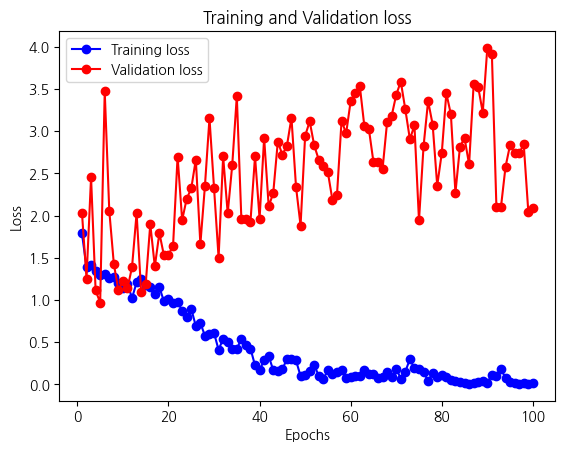

In [20]:
display_history(history_best)

### 10. 모델 평가 해보기

In [21]:
# 모델 평가
evaluate(model_ResNet_best, test_loader)

테스트 이미지 정확도 계산: 57.08%


0.5708333253860474

### 11. best 모델 불러오기 및 평가

In [34]:
# 모델 구조 재생성
load_model_best = models.resnet18(weights=None, num_classes=4)
load_model_best.load_state_dict(torch.load('best_model.pth'))

# 모델 출력해보기
evaluate(load_model_best, test_loader)

테스트 이미지 정확도 계산: 50.83%


0.5083333253860474

In [32]:
load_model_best

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  